In [3]:
import sys
sys.path.append("../")

In [4]:
INTERVAL_LOW = 0
INTERVAL_HIGH = 100

In [5]:
import random

INTERVAL_LOW = 0
INTERVAL_HIGH = 100
SAMPLES = int(1e5)

a = 10
b = 28
c = 8/3
normalization_factor = 100

def system(y, t,a,b,c):
    x, y, z = y   
    dxdt = a * (y - x)
    dydt = x * (b - z) - y
    dzdt = x * y - c * z
    return dxdt, dydt, dzdt

def get_time_norm_function(function, max_time):
    def function_norm_time(t):
        return function(t * max_time)

    return function_norm_time


def initial_conditions(number_of_initial_conditions):
    def generate_initial_conditions():
        x = random.uniform(-20,20)
        y = random.uniform(-20,20)
        z = random.uniform(-20,20)
        return  [x,y,z]
    
    yield [-8,7,27 ]
    for i in range(number_of_initial_conditions -1):  
        yield generate_initial_conditions()

include_time = True
# The ideal trained neural network model
class ExactModel:
    def eval_model(self, X):
        if include_time:
            return [a * (X[2]*normalization_factor - X[1] * normalization_factor)]
        else:
            return [a * (X[1]*normalization_factor - X[0] * normalization_factor)]
#         if include_time:
#             return [X[1]*normalization_factor * (b - X[3]*normalization_factor) - X[2] * normalization_factor]
#         else:
#             return [X[0]*normalization_factor * (b - X[2]*normalization_factor) - X[1] * normalization_factor]
#         if include_time:
#             return [X[1] *normalization_factor * X[2] * normalization_factor - c * X[3] * normalization_factor]
#         else:
#             return [X[0] *normalization_factor * X[1] * normalization_factor - c * X[2] * normalization_factor]

exact = ExactModel()

Generating training data...
[-8, 7, 27]
Done


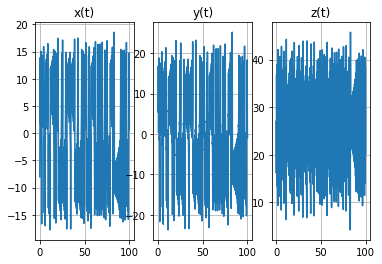

In [6]:
from interpolation.interpolate_system import odeint_interpolate
from interpolation.regression_dataset import RegressionDataset

import matplotlib.pyplot as plt
import numpy as np


number_of_systems = 1
samples_per_system = 1000000

dataset_train = None
dataset_test = None


print("Generating training data...")
# f, axes = plt.subplots(2, 1, sharex='col', sharey='col', figsize=(7, 15))
f, axes = plt.subplots(1, 3)

for init_conditions in initial_conditions(number_of_systems):
    print(init_conditions)
    y_inter = odeint_interpolate( system, init_conditions, INTERVAL_LOW, INTERVAL_HIGH, 10000, (a,b,c))
    y_inter_time_norm = [get_time_norm_function(yi, INTERVAL_HIGH) for yi in y_inter]
    
    t = np.linspace(INTERVAL_LOW, INTERVAL_HIGH, 10000)
    X,Y, Z = y_inter

    axes[0].plot(t, [X(ti) for ti in t])
    axes[1].plot(t, [Y(ti) for ti in t])
    axes[2].plot(t, [Z(ti) for ti in t])
    
#     print(init_conditions)

    def y_prime(t):
        return a * (y_inter_time_norm[1](t) - y_inter_time_norm[0](t))
#         return y_inter_time_norm[0](t) * ( b - y_inter_time_norm[2](t)) - y_inter_time_norm[1](t)
#         return y_inter_time_norm[0](t) * y_inter_time_norm[1](t) - c * y_inter_time_norm[2](t)

    d_train = RegressionDataset(y_inter_time_norm, y_prime, normalization_factor, samples_per_system * 80 // 100, include_time, 0, 1)
    d_test = RegressionDataset(y_inter_time_norm, y_prime, normalization_factor, samples_per_system * 20 // 100, include_time, 0, 1)
   
    if dataset_train:
        dataset_train.concat_dataset(d_train)
        dataset_test.concat_dataset(d_test)
    else:
        dataset_train = d_train
        dataset_test = d_test




print("Done")
axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[0].set_title("x(t)")
axes[1].set_title("y(t)")
axes[2].set_title("z(t)")

# plt.savefig('lotka_volterra_example_two_initial_conditions.png')
plt.show()

In [8]:
%load_ext autoreload
%autoreload 2
from interpolation.regression_nn import RegressionNN
m1 = RegressionNN.nn_dataset_regression(dataset_train, dataset_test,1000, 50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB
epoch: 0
train_loss: 332.32569258379687
test_loss: 20.86027359743554


KeyboardInterrupt: 

In [ ]:
y_inter = odeint_interpolate( system, init_conditions, INTERVAL_LOW, INTERVAL_HIGH, 10000, (a,b,c))
y_inter_time_norm = [get_time_norm_function(yi, INTERVAL_HIGH) for yi in y_inter]

In [ ]:
%load_ext autoreload
%autoreload 2
from query_set.check_var_exist import check_var_exist_grad_dataset
# import math 

# def rmsValue(arr, n):
#     square = 0
#     mean = 0.0
#     root = 0.0
     
#     #Calculate square
#     for i in range(0,n):
#         square += (arr[i]**2)
     
#     #Calculate Mean
#     mean = (square / (float)(n))
     
#     #Calculate Root
#     root = math.sqrt(mean)
     
#     return root

# n = min(100000, len(dataset_train.X))
values = check_var_exist_grad_dataset(m1, 0, dataset_train)
avr = sum(values)/len(values)
print(avr)


values = check_var_exist_grad_dataset(m1, 1, dataset_train)
avr = sum(values)/len(values)
print(avr)


values = check_var_exist_grad_dataset(m1, 2, dataset_train)
avr = sum(values)/len(values)
print(avr)

values = check_var_exist_grad_dataset(m1, 3, dataset_train)
avr = sum(values)/len(values)
print(avr)

In [ ]:
%load_ext autoreload
%autoreload 2
from query_set.regression_dependency import check_polynomial_dependency

result = check_polynomial_dependency(
        m1,
        2,
        y_inter_time_norm,
        0.25,
        0.75,
        3,
        normalization_factor,
        10,
        1000,
        include_time)

print(result)